# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [23]:
import importlib

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# %load_ext autoreload
# %autoreload 2

In [2]:
import dataset
import gradient_check
import layers
import model
import trainer
import optim
import metrics


# from dataset import load_svhn, random_split_train_val
# from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
# from layers import FullyConnectedLayer, ReLULayer
# from model import TwoLayerNet
# from trainer import Trainer, Dataset
# from optim import SGD, MomentumSGD
# from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = dataset.load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = dataset.random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [5]:
# importlib.reload(layers)
# importlib.reload(gradient_check)

# Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]])

assert gradient_check.check_layer_gradient(layers.ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# importlib.reload(layers)
# importlib.reload(gradient_check)

# Implement FullyConnected layer forward and backward methods
assert gradient_check.check_layer_gradient(layers.FullyConnectedLayer(3, 4), X)

# Implement storing gradients for W and B
assert gradient_check.check_layer_param_gradient(layers.FullyConnectedLayer(3, 4), X, 'W')
assert gradient_check.check_layer_param_gradient(layers.FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# importlib.reload(model)
# importlib.reload(layers)
# importlib.reload(gradient_check)

# In model.py, implement compute_loss_and_gradients function
nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = nn.compute_loss_and_gradients(train_X[:2], train_y[:2])

# Now implement backward pass and aggregate all of the params
gradient_check.check_model_gradient(nn, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# importlib.reload(model)
# importlib.reload(layers)
# importlib.reload(gradient_check)

# Now implement L2 regularization in the forward and backward pass
nn_with_reg = model.TwoLayerNet(n_input=train_X.shape[1], n_output =10, hidden_layer_size=3, reg=1e1)
loss_with_reg = nn_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])

assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

gradient_check.check_model_gradient(nn_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# importlib.reload(metrics)

# Finally, implement predict function!
# What would be the value we expect?
metrics.multiclass_accuracy(nn_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [10]:
# importlib.reload(model)
# importlib.reload(trainer)
# importlib.reload(layers)
# importlib.reload(gradient_check)

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e1)
dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
coach = trainer.Trainer(nn, dataset, optim.SGD(), learning_rate=1e-2, verbose=True)

# Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = coach.fit()

Loss: 2.302491, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302451, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302476, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302536, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302488, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302381, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302424, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302486, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302473, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302558, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302561, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302531, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302597, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302473, Train acc

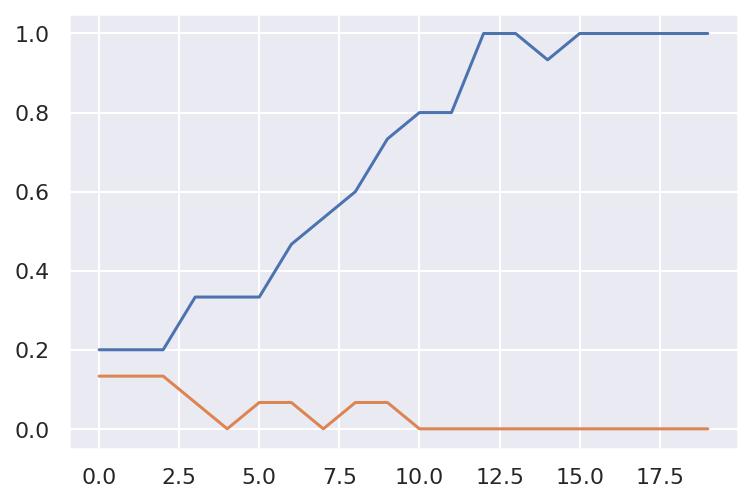

In [24]:
plt.plot(train_history)
plt.plot(val_history);

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# importlib.reload(trainer)

# Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
coach = trainer.Trainer(nn, dataset, optim.SGD(), learning_rate_decay=0.99, verbose=True)

initial_learning_rate = coach.learning_rate
loss_history, train_history, val_history = coach.fit()

assert coach.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert coach.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn't've been reduced that much!"

Loss: 2.302239, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308332, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289100, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306072, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250868, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291086, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212819, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325159, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.313145, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.238692, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286604, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.355889, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233891, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.379898, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259309, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# importlib.reload(trainer)
# importlib.reload(optim)

# Implement MomentumSGD.update function in optim.py

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
coach = trainer.Trainer(nn, dataset, optim.MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99, verbose=True)

# You should see even better results than before!
loss_history, train_history, val_history = coach.fit()

Loss: 2.328003, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.322595, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320111, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311517, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309783, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312030, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305316, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305544, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302871, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303209, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301828, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305645, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297752, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302125, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301015, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298528, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = trainer.Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
coach = trainer.Trainer(nn, dataset, optim.SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5, verbose=True)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = coach.fit()

Loss: 2.339515, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.324188, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.312022, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.329603, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.312070, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.316725, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.277508, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.233979, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.162042, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.025126, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.906637, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.266989, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.674035, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.259103, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.959786, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.663200, Train acc

Loss: 1.086129, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.535074, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.401894, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.195483, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.536462, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.383212, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.469463, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.311500, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.361495, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.549090, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.499534, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-4)
dataset = trainer.Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])

# Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
coach = trainer.Trainer(nn, dataset, optim.MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5, verbose=True)

loss_history, train_history, val_history = coach.fit()

Loss: 2.300141, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.289029, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.208929, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.208650, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.151360, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.521952, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.452000, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.549387, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.810772, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.634956, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.900869, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.695338, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.104058, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.250574, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.056044, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.035942, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [73]:
import warnings
import csv
import json

from datetime import datetime
from timeit import default_timer as timer

from hyperopt import STATUS_OK, Trials, hp, tpe, fmin
from hyperopt.pyll.stochastic import sample
from hyperopt.pyll.base import scope

In [149]:
max_epochs = 200

space = {
    'model__learning_rate_10pow': hp.uniform('learning_rate_10pow', -2.25, -0.75),
    'model__reg_strength_10pow': hp.uniform('reg_strength_10pow', -4, -2.5),
    'model__learning_rate_decay': hp.uniform('learning_rate_decay', 0.85, 1.0),
    'model__hidden_layer_size': hp.quniform('hidden_layer_size', 32, 128, 1),
    'model__batch_size': hp.quniform('batch_size', 32, 128, 1)
}

space_keys = list(space.keys())

In [150]:
sample(space)

{'model__batch_size': 95.0,
 'model__hidden_layer_size': 78.0,
 'model__learning_rate_10pow': -1.2547772985383059,
 'model__learning_rate_decay': 0.9069910240330535,
 'model__reg_strength_10pow': -2.985611811653176}

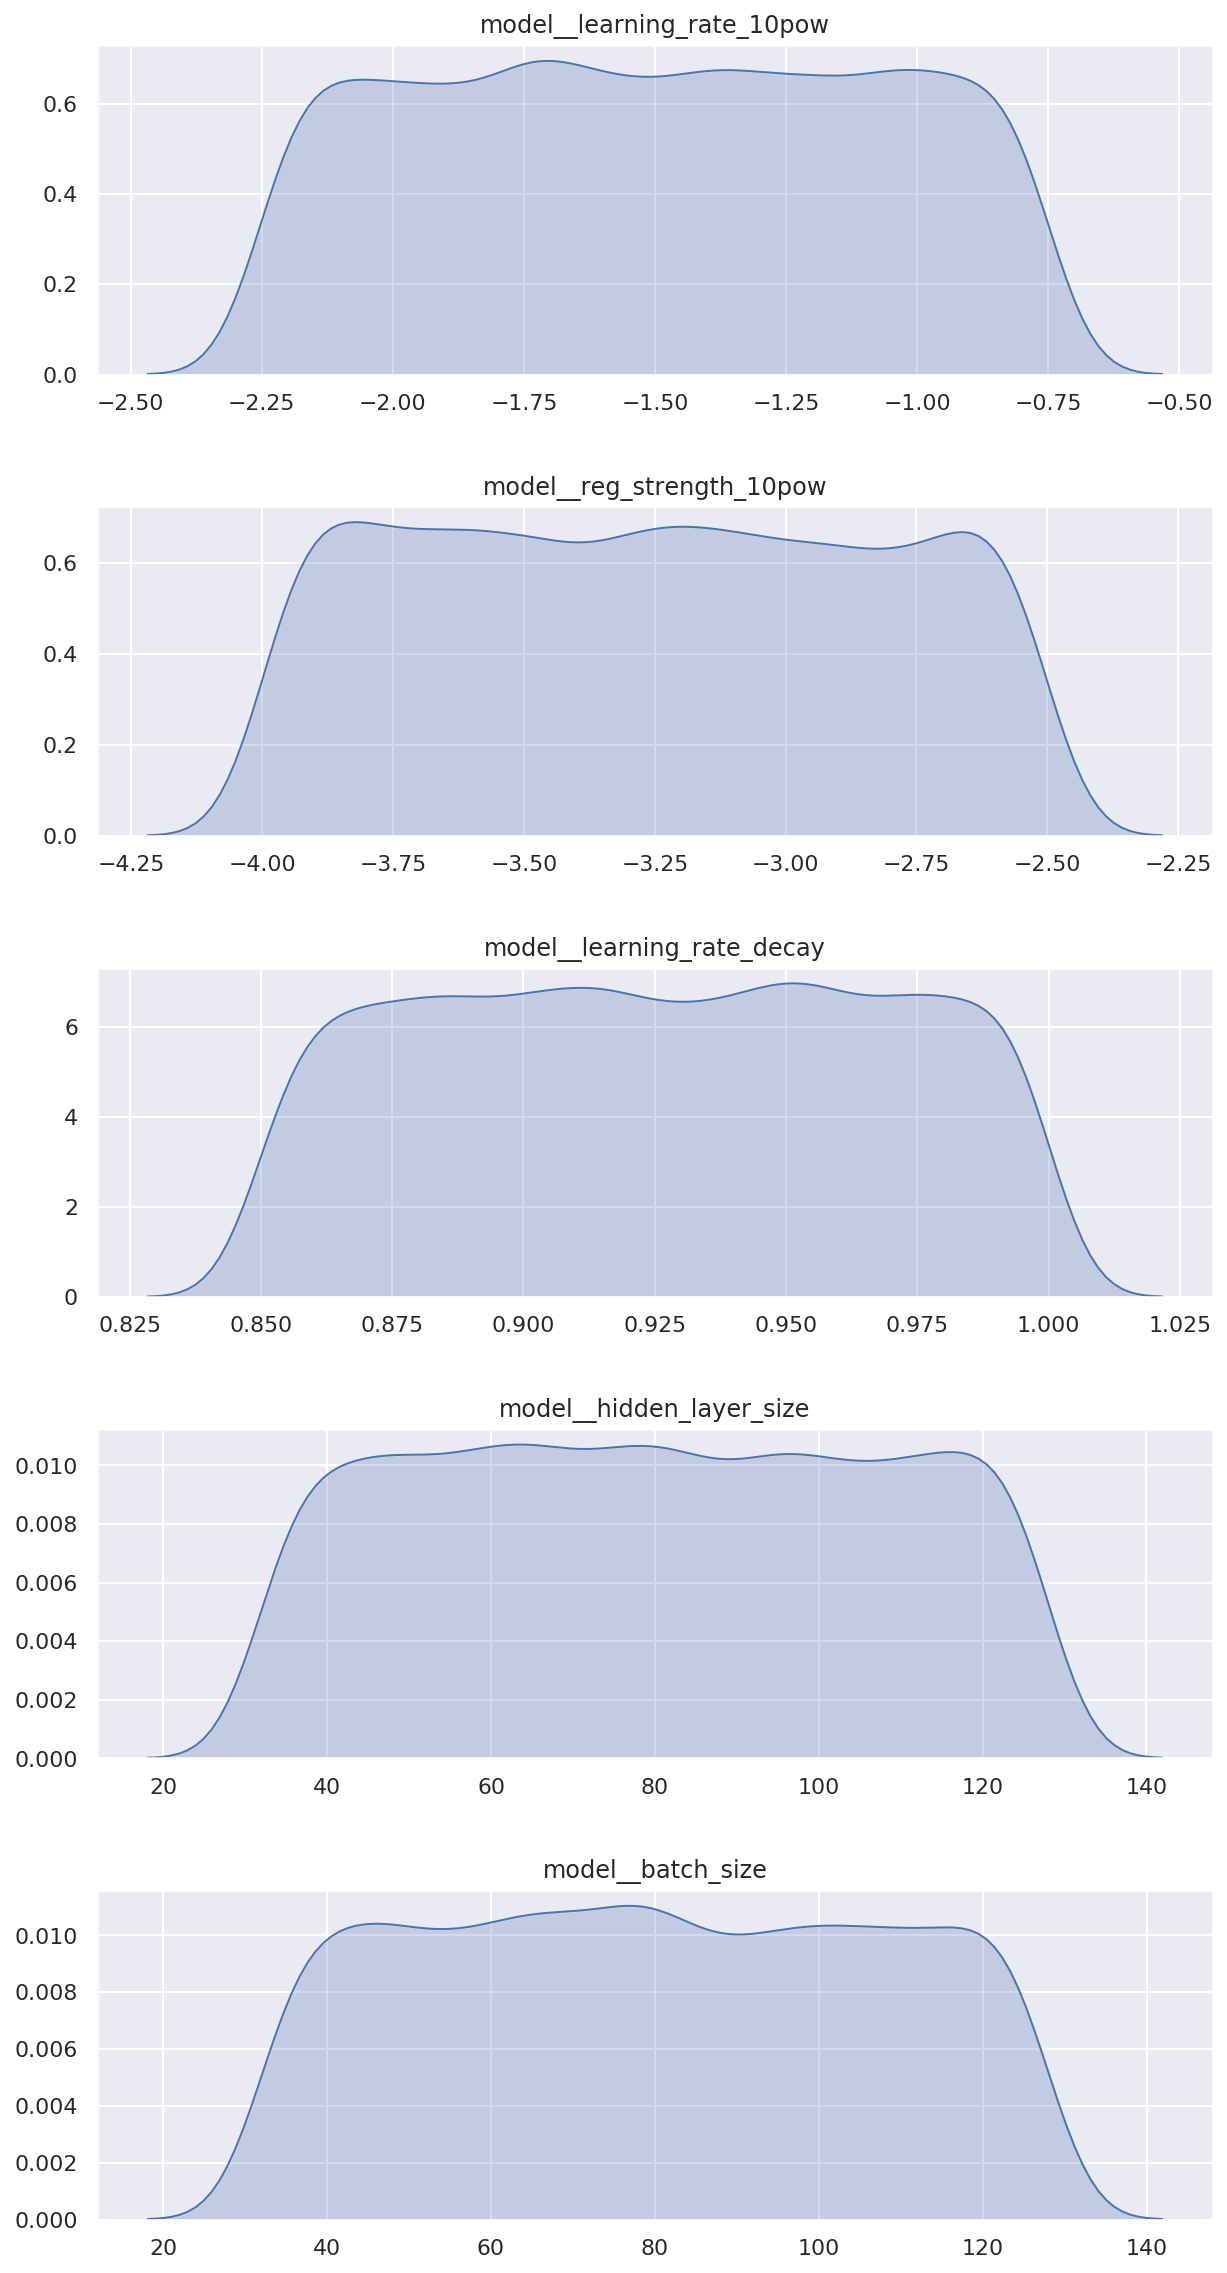

In [151]:
samples = [sample(space) for _ in range(10000)]

_, axes = plt.subplots(len(space_keys), 1, figsize=(10, 4 * len(space_keys)))
plt.subplots_adjust(hspace=0.4)

for i, key in enumerate(space_keys):
    values = [x[key] for x in samples]        
    sns.kdeplot(values, linewidth=1, shade=True, ax=axes[i])
    axes[i].title.set_text(key)

In [152]:
time_postfix = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
trials_filename = 'temp/nn_trials_%s.csv' % time_postfix

print('Trials log: %s' % trials_filename)

space_keys = (space_keys + ['model__num_epochs'])

with open(trials_filename, 'x') as trials_out:
    writer = csv.writer(trials_out)
    header = ['iteration', 'loss', 'train_acc', 'val_acc', 'elapsed_time_sec', 'params'] + space_keys
    writer.writerow(header)
    

global iteration
iteration = 0

def objective(params):
    global iteration
    
    learning_rate_10pow = float(np.clip(params['model__learning_rate_10pow'], -8, None))
    reg_strength_10pow = float(np.clip(params['model__reg_strength_10pow'], -8, None))
    learning_rate_decay = float(np.clip(params['model__learning_rate_decay'], 0.0, 1.0))
    hidden_layer_size = int(np.round(np.clip(params['model__hidden_layer_size'], 1, 10000)))
    batch_size = int(np.round(np.clip(params['model__batch_size'], 1, 10000)))
    
    learning_rate = math.pow(10.0, learning_rate_10pow)
    reg_strength = math.pow(10.0, reg_strength_10pow)

    dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
    
    nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                           hidden_layer_size=hidden_layer_size, 
                           reg=reg_strength)
    
    coach = trainer.Trainer(nn, dataset, optim.MomentumSGD(), # verbose=True,
                            learning_rate=learning_rate, 
                            learning_rate_decay=learning_rate_decay, 
                            num_epochs=max_epochs, 
                            batch_size=batch_size)
    
    start = timer()
    
    loss_history, train_accuracy, val_accuracy = coach.fit()

    best_epoch = int(np.argmax(val_accuracy))
    params['model__num_epochs'] = best_epoch + 1
            
    loss = loss_history[best_epoch]
    train_acc = train_accuracy[best_epoch]
    val_acc = val_accuracy[best_epoch]
    
    end = timer()
    
    with open(trials_filename, 'a') as trials_out:
        writer = csv.writer(trials_out)
        params_json = json.dumps(params)
        row = [iteration, loss, train_acc, val_acc, ("%.1f" % (end - start)), params_json] + [params[key] for key in space_keys]        
        writer.writerow(row)
        
    iteration += 1

    return {'loss': -val_acc, 'params': params, 'status': STATUS_OK}


warnings.simplefilter(action='ignore', category=FutureWarning)

trials = Trials() 
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10000, trials=trials, rstate=np.random.RandomState(42))

warnings.simplefilter(action='default', category=FutureWarning)

trials

Trials log: temp/nn_trials_2019-10-07_10:22:11.csv
  0%|          | 23/10000 [47:10<383:53:35, 138.52s/it, best loss: -0.795]

/home/apollo/mnt/assignment2/layers.py:63: RuntimeWarning: divide by zero encountered in log
  return np.mean(-np.log(probs[rows, cols]))  # L

/home/apollo/mnt/assignment2/layers.py:37: RuntimeWarning: overflow encountered in subtract
  predictions_ts = predictions - maximums

/home/apollo/mnt/assignment2/layers.py:37: RuntimeWarning: invalid value encountered in subtract
  predictions_ts = predictions - maximums

/home/apollo/mnt/assignment2/layers.py:110: RuntimeWarning: invalid value encountered in greater
  self.d_out_result = np.greater(X, 0).astype(float)  # dZ/dX



  0%|          | 37/10000 [1:22:07<334:23:39, 120.83s/it, best loss: -0.814]

/home/apollo/mnt/assignment2/layers.py:141: RuntimeWarning: overflow encountered in matmul
  return np.matmul(X, self.W.value) + self.B.value

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1576: RuntimeWarning: overflow encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)



  1%|          | 63/10000 [2:17:04<335:42:01, 121.62s/it, best loss: -0.814]


KeyboardInterrupt: 

In [154]:
learning_rate_10pow = -1.099643
reg_strength_10pow = -3.570692
learning_rate_decay = 0.964509
hidden_layer_size = 81
num_epochs = max_epochs
batch_size = 53

learning_rate = math.pow(10.0, learning_rate_10pow)
reg_strength = math.pow(10.0, reg_strength_10pow)

dataset = trainer.Dataset(train_X, train_y, val_X, val_y)

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                       hidden_layer_size=hidden_layer_size, 
                       reg=reg_strength)

coach = trainer.Trainer(nn, dataset, optim.MomentumSGD(), verbose=True,
                        learning_rate=learning_rate, 
                        learning_rate_decay=learning_rate_decay, 
                        num_epochs=num_epochs, 
                        batch_size=batch_size)

loss_history, train_accuracy, val_accuracy = coach.fit();

Loss: 2.190842, Train accuracy: 0.376556, val accuracy: 0.377000
Loss: 1.180049, Train accuracy: 0.502556, val accuracy: 0.503000
Loss: 1.684322, Train accuracy: 0.582333, val accuracy: 0.556000
Loss: 1.485884, Train accuracy: 0.611222, val accuracy: 0.613000
Loss: 1.166068, Train accuracy: 0.632667, val accuracy: 0.589000
Loss: 1.324938, Train accuracy: 0.649000, val accuracy: 0.615000
Loss: 1.198345, Train accuracy: 0.665222, val accuracy: 0.614000
Loss: 1.665415, Train accuracy: 0.689444, val accuracy: 0.631000
Loss: 0.790130, Train accuracy: 0.726778, val accuracy: 0.655000
Loss: 0.948364, Train accuracy: 0.702333, val accuracy: 0.634000
Loss: 1.187073, Train accuracy: 0.745333, val accuracy: 0.682000
Loss: 0.892401, Train accuracy: 0.747000, val accuracy: 0.668000
Loss: 1.101870, Train accuracy: 0.763667, val accuracy: 0.697000
Loss: 1.414951, Train accuracy: 0.789222, val accuracy: 0.705000
Loss: 1.637355, Train accuracy: 0.727778, val accuracy: 0.656000
Loss: 1.027680, Train acc

Loss: 0.330409, Train accuracy: 0.991667, val accuracy: 0.777000
Loss: 0.284253, Train accuracy: 0.991556, val accuracy: 0.781000
Loss: 0.288749, Train accuracy: 0.992000, val accuracy: 0.776000
Loss: 0.285965, Train accuracy: 0.991889, val accuracy: 0.776000
Loss: 0.335326, Train accuracy: 0.992444, val accuracy: 0.777000
Loss: 0.309396, Train accuracy: 0.992000, val accuracy: 0.776000
Loss: 0.262233, Train accuracy: 0.991889, val accuracy: 0.775000
Loss: 0.337759, Train accuracy: 0.992222, val accuracy: 0.777000
Loss: 0.262827, Train accuracy: 0.992111, val accuracy: 0.777000
Loss: 0.300320, Train accuracy: 0.991667, val accuracy: 0.776000
Loss: 0.366555, Train accuracy: 0.992111, val accuracy: 0.776000
Loss: 0.278901, Train accuracy: 0.992444, val accuracy: 0.778000
Loss: 0.296926, Train accuracy: 0.991889, val accuracy: 0.775000
Loss: 0.313628, Train accuracy: 0.992222, val accuracy: 0.776000
Loss: 0.313667, Train accuracy: 0.992778, val accuracy: 0.776000
Loss: 0.306146, Train acc

In [155]:
best_classifier = nn
best_val_accuracy = val_accuracy[np.argmax(val_accuracy)]

# find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.783000


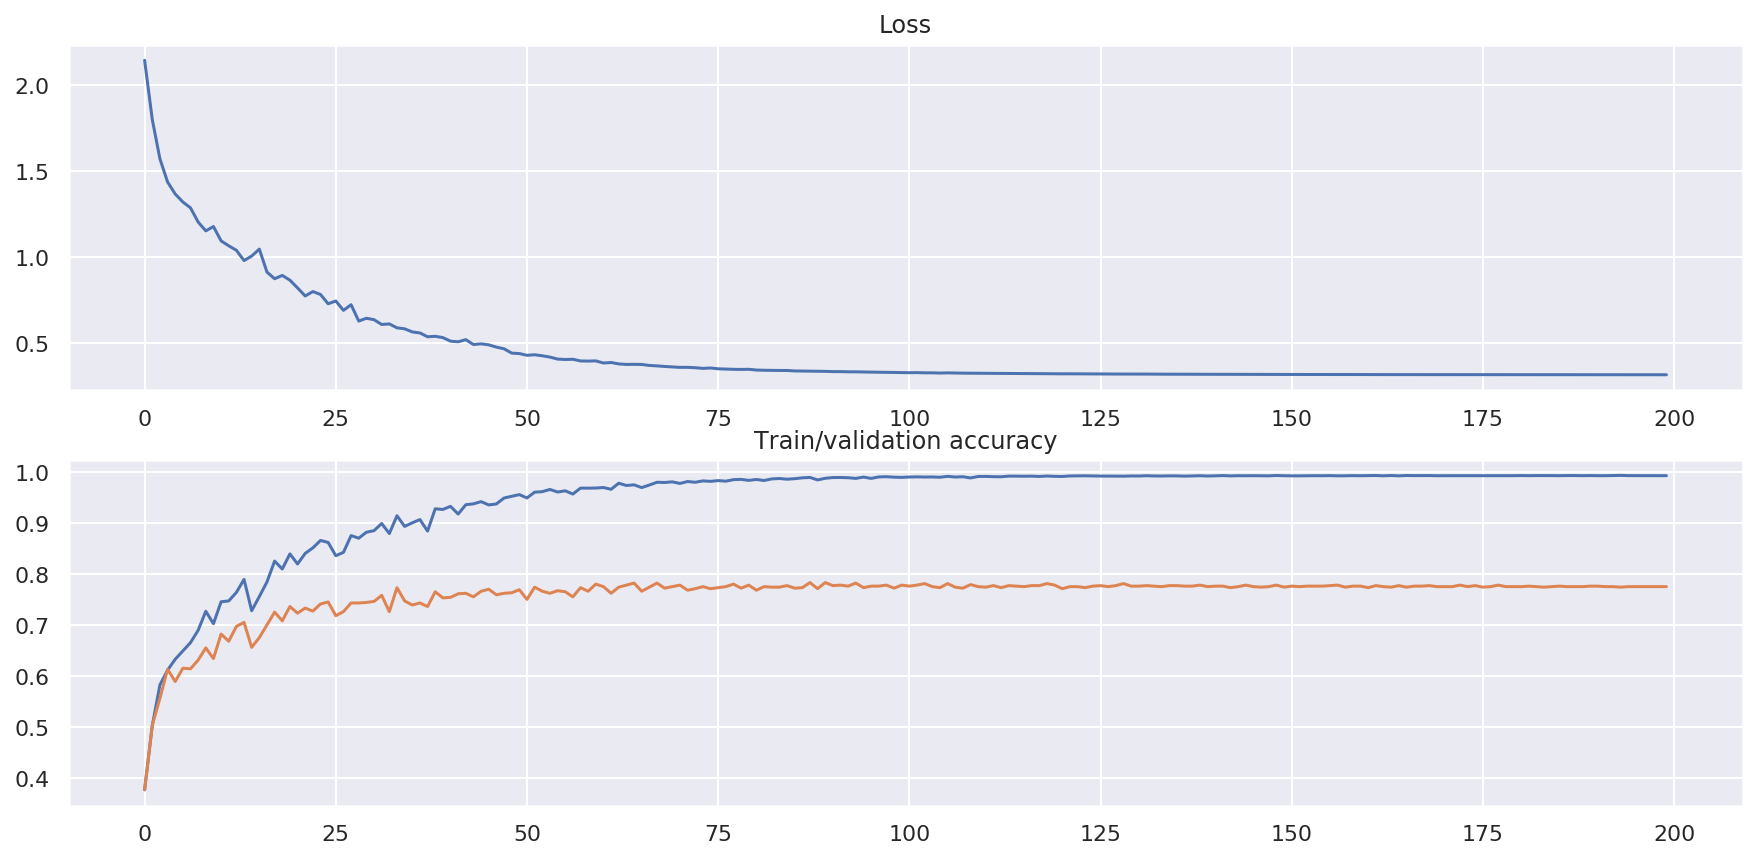

In [157]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_accuracy)
plt.plot(val_accuracy);

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [159]:
test_pred = best_classifier.predict(test_X)
test_accuracy = metrics.multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.775000
